<a href="https://colab.research.google.com/github/MBayezid/AutoSimNet/blob/main/AutoSimNet_(Visually_similar_Products_Recommendation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AutoSImNet A Recommendation System

---



---


![](https://www.researchgate.net/profile/Andreas_Veit/publication/282181243/figure/fig1/AS:360995122892808@1463079352720/Visualization-of-a-2D-embedding-of-the-style-space-trained-with-strategic-sampling.png)

#Config VM

In [ ]:
# !pip install tensorflow==2.0.0
%pip install tensorflow
%pip install opendatasets #Kaggle data downloader

#Import Librarys

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import opendatasets as od

import keras

import tensorflow as tf
# import keras

from tensorflow.keras.preprocessing import image #for image modification
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

tf.__version__

'2.18.0'

#--

In [ ]:
# Small version

# od.download("https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset")
od.download("https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small")
#Use ur owne user name and key from kaggl..

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: musannabayezid
Your Kaggle Key: ··········


100%|██████████| 565M/565M [00:06<00:00, 96.5MB/s]


#Load Data set from Kaggel

In [ ]:
DATASET_PATH = "/content/fashion-product-images-small"
print(os.listdir(DATASET_PATH))

In [ ]:
# df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df=pd.read_csv(os.path.join(DATASET_PATH,'styles.csv'), error_bad_lines=False)
# df=pd.read_csv(os.path.join(DATASET_PATH,'styles.csv'), error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)



In [ ]:
# df=df.dropna()
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(44424, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [ ]:
# df=df.dropna()
print(df.isnull().sum())
print(df.shape)

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
image                   0
dtype: int64
(44424, 11)


In [ ]:
df=df.dropna()

In [ ]:
# df=df.dropna()
print(df.isnull().sum())
print(df.shape)

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image                 0
dtype: int64
(44077, 11)


# Helper Functions (Plot, Image Path, Reshape)

In [ ]:

# # Plot/view images in multiple coloums and rows
# def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
#     """Plot a dictionary of figures.

#     Parameters
#     ----------
#     figures : <title, figure> dictionary
#     ncols : number of columns of subplots wanted in the display
#     nrows : number of rows of subplots wanted in the figure
#     """
#     fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
#     for ind,title in enumerate(figures):
#         axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
#         axeslist.ravel()[ind].set_title(title)
#         axeslist.ravel()[ind].set_axis_off()
#     plt.tight_layout() # optional

# create image location for any image id.jpg
def img_path(img):
    return DATASET_PATH+"/images/"+img

# load and resize images by into (fraction*W x fraction*H) lower resulation
def load_image(img):
  if any(c in '/' for c in img):
    img = cv2.imread(img)
  else:
    img = cv2.imread(img_path(img))
  return img

# Resize image
def reshape_image(img, IMG_SIZE):
  img = load_image(img)
  img = cv2.resize(img, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = np.array(img / 255.)
  img = img.astype('float32')
  return img

#Image Resizing


In [ ]:
df['image'][5]

'1855.jpg'

In [ ]:
IMG_SIZE = 64

resized_imgs = []

for i in df.image:
  try:
    resized_imgs.append(reshape_image(i, IMG_SIZE))
  except:
    continue
resized_imgs = np.array(resized_imgs)
resized_imgs.shape

(44072, 64, 64)

In [ ]:
print("Min and max pixel values:", resized_imgs.min(), resized_imgs.max())

Min and max pixel values: 0.0 1.0


#Image Augmentation

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   layers.Reshape((IMG_SIZE,IMG_SIZE,1), input_shape=(IMG_SIZE,IMG_SIZE)),
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.08),
#   # layers.RandomTranslation(width_factor=.2, height_factor=.2),
#   # layers.RandomCrop(width=IMG_SIZE, height=IMG_SIZE, seed=.2),
# ])

# resized_imgs = data_augmentation(resized_imgs)
# resized_imgs.shape

TensorShape([6695, 224, 224, 1])

#Image Ploting

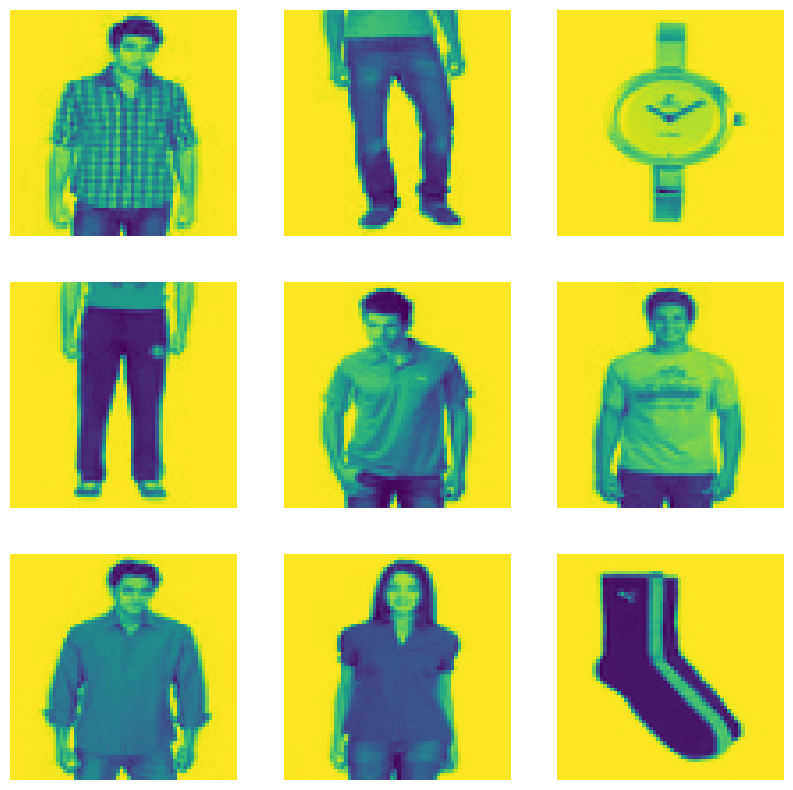

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(resized_imgs[i])
  plt.axis("off")



---






---


#Denoising Autoencoder

---



## Adding random noise to the image.

In [ ]:
df.subCategory[:resized_imgs.shape[0]].shape

(6631,)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(resized_imgs), df[:resized_imgs.shape[0]], test_size=.2, shuffle=False ,random_state=41)

In [ ]:
y_train.id

0       15970
1       39386
2       59263
3       21379
4       53759
        ...  
5351    45660
5352     4547
5353    36392
5354    17223
5355    47553
Name: id, Length: 5304, dtype: int64

In [ ]:
noise_factor = 0.07
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [ ]:
x_train.shape

(5304, 64, 64)

## Plotting a noisy image.

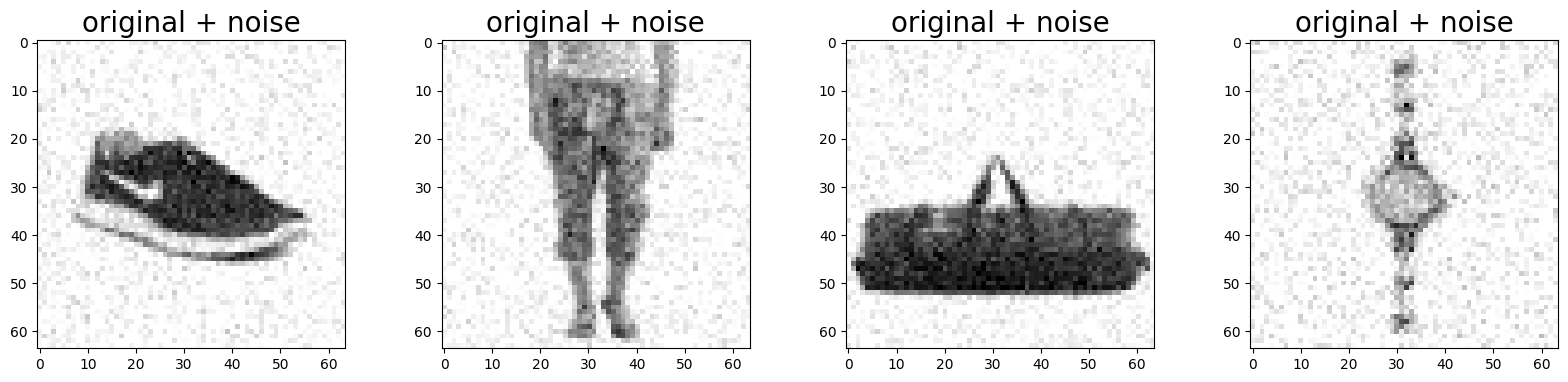

In [ ]:
n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Train (Denoising Autoencoder)

In [ ]:
latent=2048

...
# define encoder
input = layers.Input(shape=(64, 64, 1))
# n_inputs = 64*64
# # encoder level 1
# x = layers.Flatten()(input)
# x = layers.Dense(n_inputs*2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
# # encoder level 2
# x = layers.Dense(n_inputs)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
# # bottleneck
# x = layers.Dense(latent, name='lattent')(x)
# Encoder
x = layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same", name='bottleneck')(x)
# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation=LeakyReLU(), padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation=LeakyReLU(), padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation=LeakyReLU(), padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
# ...
# # define decoder, level 1
# x = layers.Dense(n_inputs)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
# # decoder level 2
# x = layers.Dense(n_inputs*2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU()(x)
# # output layer
# x = layers.Dense(n_inputs, activation='relu')(x)
# output = layers.Reshape((64,64))(x)
# define autoencoder model
model = Model(inputs=input, outputs=x, name='AE_onFashionDataSets')


...
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_86 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_87 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 16, 16, 32)       0        

In [ ]:
# fit the autoencoder model to reconstruct input
history = model.fit(x_train_noisy, x_train, epochs=100, batch_size=16, verbose=2, validation_data=(x_test_noisy, x_test))

Epoch 1/100
335/335 - 7s - loss: 0.0135 - val_loss: 0.0479 - 7s/epoch - 21ms/step
Epoch 2/100
335/335 - 2s - loss: 0.0051 - val_loss: 0.0058 - 2s/epoch - 7ms/step
Epoch 3/100
335/335 - 2s - loss: 0.0043 - val_loss: 0.0039 - 2s/epoch - 7ms/step
Epoch 4/100
335/335 - 3s - loss: 0.0037 - val_loss: 0.0038 - 3s/epoch - 8ms/step
Epoch 5/100
335/335 - 3s - loss: 0.0033 - val_loss: 0.0032 - 3s/epoch - 8ms/step
Epoch 6/100
335/335 - 2s - loss: 0.0031 - val_loss: 0.0030 - 2s/epoch - 6ms/step
Epoch 7/100
335/335 - 2s - loss: 0.0030 - val_loss: 0.0029 - 2s/epoch - 7ms/step
Epoch 8/100
335/335 - 2s - loss: 0.0028 - val_loss: 0.0027 - 2s/epoch - 7ms/step
Epoch 9/100
335/335 - 2s - loss: 0.0027 - val_loss: 0.0028 - 2s/epoch - 7ms/step
Epoch 10/100
335/335 - 3s - loss: 0.0026 - val_loss: 0.0026 - 3s/epoch - 9ms/step
Epoch 11/100
335/335 - 2s - loss: 0.0025 - val_loss: 0.0027 - 2s/epoch - 7ms/step
Epoch 12/100
335/335 - 2s - loss: 0.0025 - val_loss: 0.0025 - 2s/epoch - 7ms/step
Epoch 13/100
335/335 - 2

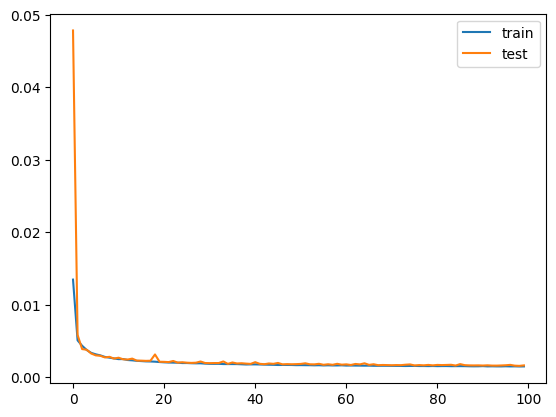

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Saving model*

In [ ]:
# model = autoencoder # Get model (Sequential, Functional Model, or Model subclass)
model.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning(DL)/Visually Similar Product/records/AutoSimNet-V1.h5')

#Load pretrained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning(DL)/Visually Similar Product/records/AutoSimNet-V1.h5')
model.summary()

## Checking results

Plots both the noisy and denoised images generated by the autoencoder.

In [ ]:
# print(model.summary())
decoded_imgs = model.predict(x_test[:10])
decoded_imgs.shape

1/1 [==============================] - 0s 475ms/step


(10, 64, 64, 1)

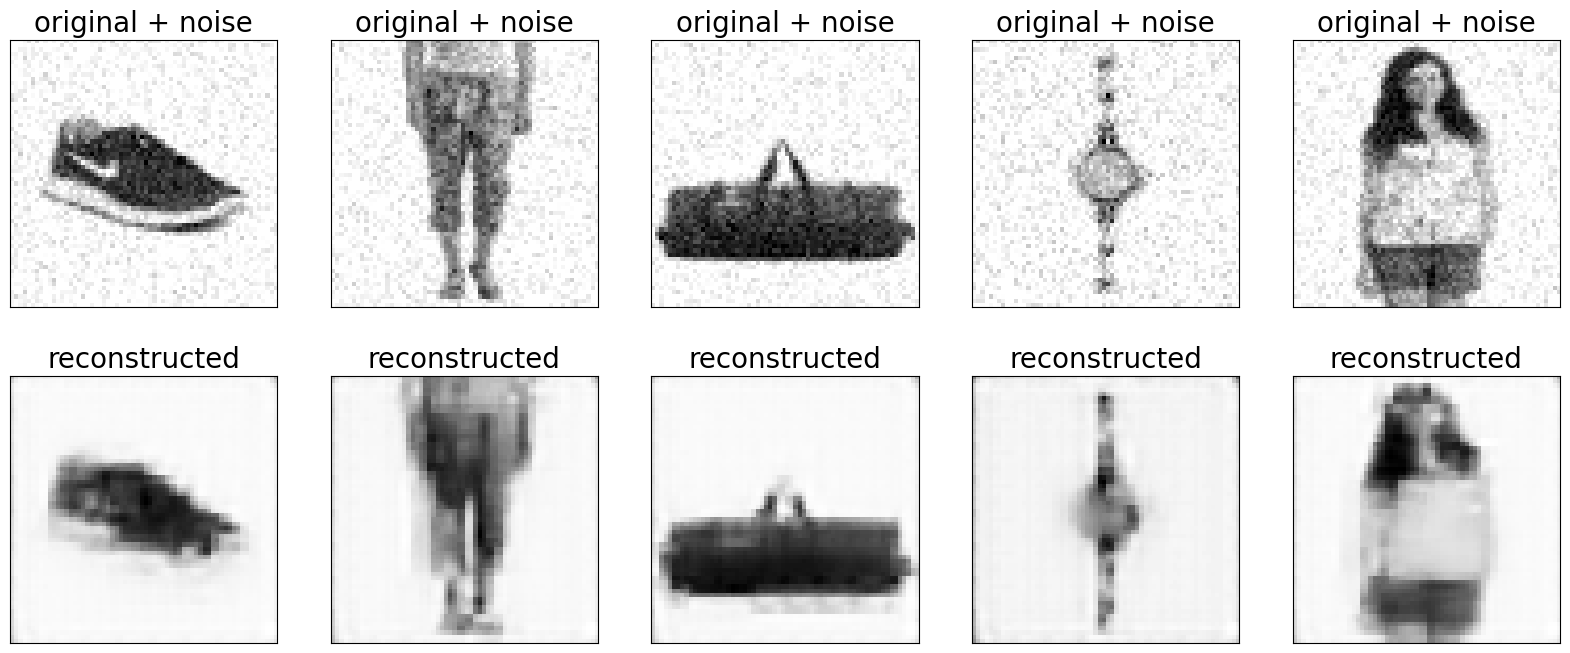

In [ ]:
n = 5
plt.figure(figsize=(20, 8))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed",fontsize=20)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

#
---

# Create Embadder Model and Lattent Space

In [ ]:
# model_output = autoencoder.get_layer("max_pooling2d_1").output
encoder = Model(inputs= model.input, outputs = model.get_layer("bottleneck").output)

In [ ]:
encoder = tf.keras.Sequential([encoder,
                     layers.Flatten()
                     ])
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 32)          19072     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 19,072
Trainable params: 18,944
Non-trainable params: 128
_________________________________________________________________


In [ ]:
#if data set not splited before!!
print(resized_imgs.shape)
df_embedding = encoder.predict(resized_imgs)

(6631, 64, 64)
208/208 [==============================] - 14s 68ms/step


In [ ]:
#if data set was splited before!!
x_train = encoder.predict(x_train)
print(x_train.shape)

x_test = encoder.predict(x_test)
print(x_test.shape)

168/168 [==============================] - 10s 58ms/step


(5356, 2048)

42/42 [==============================] - 4s 83ms/step


(1339, 2048)



---


#Live recommendation using KNN

---

Return k nearest points as recommendation

##Train KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, y_train.subCategory)

KNeighborsClassifier()

In [ ]:
train_accuracy = knn.score(x_train, y_train.subCategory)
print('train_accuracy: ',train_accuracy)

test_accuracy = knn.score(x_test, y_test.subCategory)
print('test_accuracy: ',test_accuracy)

train_accuracy:  0.9100074682598954
test_accuracy:  0.8521284540702017


##Recommendation

(64, 64)
64
1/1 [==============================] - 0s 24ms/step


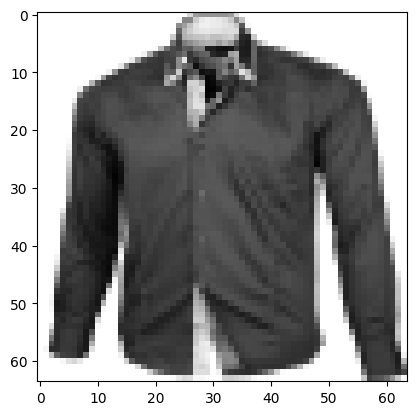

In [ ]:
path='/content/shirt-png-hd-dress-shirt-png-image-dress-shirt-png-914.png'
test = reshape_image(path,64)
plt.imshow(test)
print(test.shape)
print(len(test))

# embade single previwed item
test = encoder.predict(test.reshape((1,64,64,1)))

# embade single previwed item
# emb = get_embedding(model, path)

In [ ]:


print(len(test))
print(test.shape)
test

1
(1, 2048)


array([[ 0.9901103 , -1.8806081 , -1.3566785 , ...,  2.8425252 ,
        -0.25237456,  1.2142619 ]], dtype=float32)

In [ ]:
test.reshape(-1, 1).shape

(2048, 1)

In [ ]:
neighbors = knn.kneighbors(test, 10, False)
neighbors = neighbors.reshape(neighbors.shape[1],1)
recomended_images=[]
for i in neighbors:
  i=int(i)
  n=df['image'][i : (i+1)]
  image_id=''
  for i in n:
    image_id=str(i)
    recomended_images.append(image_id)
  # print(image_id)
print(recomended_images)

['12368.jpg', '10400.jpg', '29910.jpg', '12361.jpg', '12369.jpg', '26794.jpg', '3708.jpg', '30096.jpg', '9661.jpg', '12360.jpg']


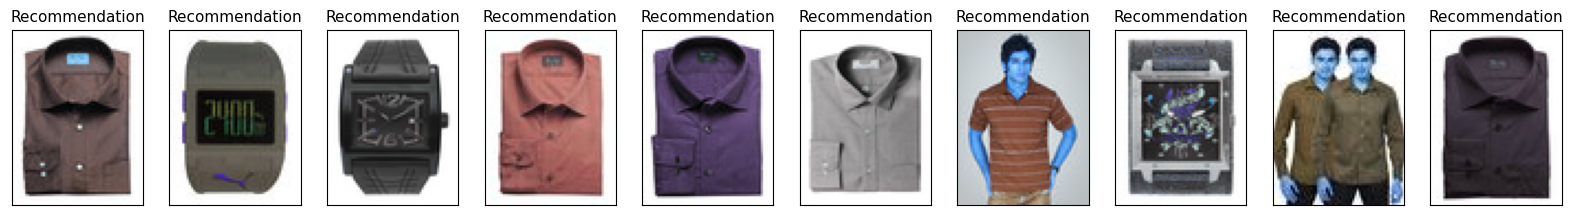

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(recomended_images)):
  # display original
  ax = plt.subplot(2, len(recomended_images), i + 1)
  plt.imshow(load_image(recomended_images[i]))
  plt.title('Recommendation',fontsize=11)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)



---

#Live recommendation using ANNOY
Approximate nearest neighbor

https://pypi.org/project/annoy/

##Create Annoy

In [ ]:
%pip install -q annoy

from annoy import AnnoyIndex
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
test.reshape(test.shape[1],1).shape

(2048, 1)

In [ ]:

f = len(df_embedding[1])  # Length of item vector that will be indexed
#Add all Vectors
matrixType='angular'
t = AnnoyIndex(f, matrixType)
for index,data in zip(df.id, df_embedding):
    t.add_item(index, data)

# add user input Vector
t.add_item(0,test.reshape(test.shape[1],1))

t.build(10) # 10 trees
t.save('test.ann')

# ...

True

In [ ]:
df.image[df.id==2286]

972    2286.jpg
Name: image, dtype: object

##Recommendation

In [ ]:
u = AnnoyIndex(f, matrixType)
u.load('test.ann') # super fast, will just mmap the file
neighbors = u.get_nns_by_item(0, 10)

recomended_images = []
for i in neighbors[1:]:
  i=int(i)
  n=df.image[df.id==i]
  image_id=''
  for i in n:
    image_id=str(i)
    recomended_images.append(image_id)
  # print(image_id)
print(recomended_images)
print(neighbors[1:]) # will find the 1000 nearest neighbors

['10400.jpg', '2286.jpg', '29910.jpg', '29745.jpg', '12368.jpg', '12360.jpg', '12369.jpg', '12361.jpg', '29945.jpg']
[10400, 2286, 29910, 29745, 12368, 12360, 12369, 12361, 29945]


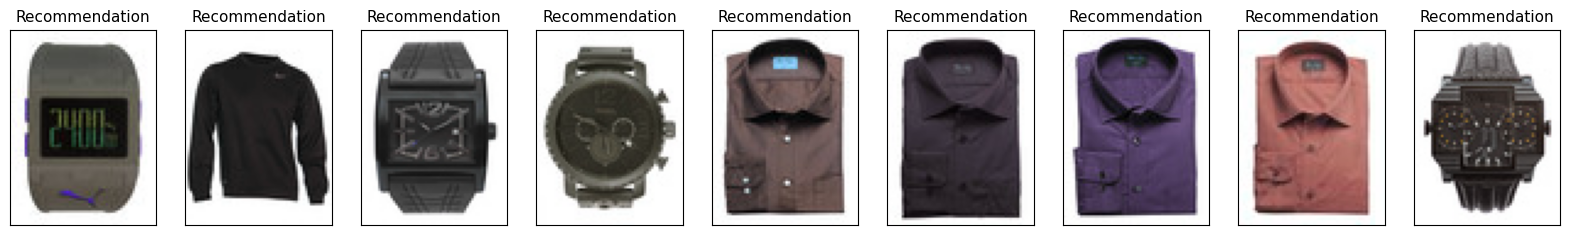

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(recomended_images)):
  # display original
  ax = plt.subplot(2, len(recomended_images), i + 1)
  plt.imshow(load_image(recomended_images[i]))
  plt.title('Recommendation',fontsize=11)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

[0, 10400, 2286, 29910, 29745, 12368, 12360, 12369, 12361, 29945]
